In [22]:
#Baseline utility packages
import numpy as np
import pandas as pd
import tensorflow as tf
from  matplotlib import pyplot as plt
#CNN packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
# Performance Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
directory = 'mask_detection/'

In [3]:
maskTrain = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.3,
    subset="training",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(152, 152),
    shuffle=True,
    seed = 12,
    interpolation="bilinear"
)

Found 2356 files belonging to 2 classes.
Using 1650 files for training.


In [4]:
maskVal = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.3,
    subset="validation",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(152, 152),
    shuffle=True,
    seed = 12,
    interpolation="bilinear"
)

Found 2356 files belonging to 2 classes.
Using 706 files for validation.


In [5]:
maskModelCNN = Sequential()

maskModelCNN.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(152, 152, 3)),)
maskModelCNN.add(layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
maskModelCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
maskModelCNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

maskModelCNN.add(layers.Dropout(0.25))
maskModelCNN.add(layers.Flatten())
maskModelCNN.add(layers.Dense(128, activation='relu'))
maskModelCNN.add(layers.Dropout(0.5))
maskModelCNN.add(layers.Dense(2, activation='softmax'))

# Print out a summary of the network
maskModelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 152, 152, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 350464)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [6]:
maskModelCNN.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [7]:
history = maskModelCNN.fit(maskTrain,
              epochs = 10,
              verbose = 1,
              validation_data = maskVal)

Epoch 1/10
52/52 [==============================] - 59s 1s/step - loss: 2.8737 - accuracy: 0.5195 - val_loss: 0.6617 - val_accuracy: 0.6303
Epoch 2/10
52/52 [==============================] - 57s 1s/step - loss: 0.6302 - accuracy: 0.6386 - val_loss: 0.6676 - val_accuracy: 0.6643
Epoch 3/10
52/52 [==============================] - 57s 1s/step - loss: 0.5693 - accuracy: 0.7303 - val_loss: 0.6486 - val_accuracy: 0.6402
Epoch 4/10
52/52 [==============================] - 56s 1s/step - loss: 0.4634 - accuracy: 0.7916 - val_loss: 0.7011 - val_accuracy: 0.6586
Epoch 5/10
52/52 [==============================] - 56s 1s/step - loss: 0.2802 - accuracy: 0.8844 - val_loss: 0.8088 - val_accuracy: 0.6586
Epoch 6/10
52/52 [==============================] - 57s 1s/step - loss: 0.1184 - accuracy: 0.9549 - val_loss: 0.9436 - val_accuracy: 0.6530
Epoch 7/10
52/52 [==============================] - 56s 1s/step - loss: 0.0702 - accuracy: 0.9761 - val_loss: 1.1413 - val_accuracy: 0.6700
Epoch 8/10
52/52 [==

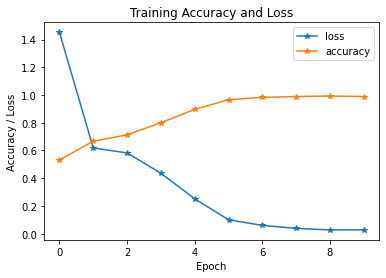

In [8]:
plt.figure()
plt.plot(history.history['loss'], marker='*', label='loss')
plt.plot(history.history['accuracy'], marker='*', label='accuracy')
plt.title('Training Accuracy and Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

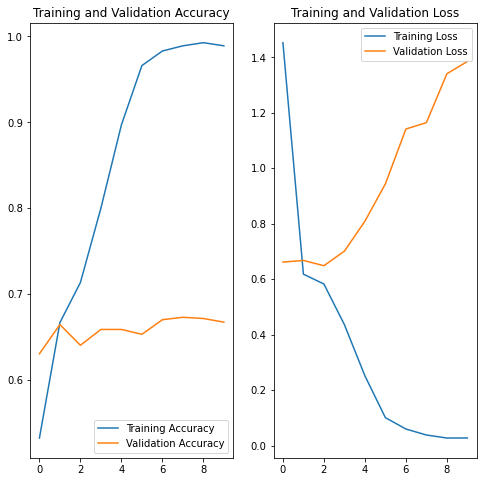

In [9]:
trainAccuracyCNNModel = history.history['accuracy']
valAccuracyCNNModel = history.history['val_accuracy']

trainLossCNNModel = history.history['loss']
valLossCNNModel = history.history['val_loss']

epochs_range = range(0,10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, trainAccuracyCNNModel, label='Training Accuracy')
plt.plot(epochs_range, valAccuracyCNNModel, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, trainLossCNNModel, label='Training Loss')
plt.plot(epochs_range, valLossCNNModel, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [10]:
testGen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
testMaskGen = testGen.flow_from_directory('test/', # path to the training data folder
                                                 target_size=(152,152),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 26 images belonging to 2 classes.


In [20]:
prediction = maskModelCNN.predict_generator(testMaskGen, steps = 1)

In [21]:
test_true = testMaskGen.classes
test_pred = prediction.argmax(axis=1)

In [24]:
pd.DataFrame(confusion_matrix(test_true,test_pred),
            index = ['true no','true yes'],
            columns =  ['predicted no','predicted yes'])

,predicted no,predicted yes
true no,13,0
true yes,13,0


In [25]:
accuracy_score(test_true,test_pred)

0.5